<a href="https://colab.research.google.com/github/reinaldoasf/deeplearning/blob/master/Reinaldo_Separador_Train_Test_das_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Separando Conjuntos de Teste e Treino

Neste notebook terá o código necessário para ler as imagens do dataset de raios X do pulmão.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount("/gdrive")#, force_remount=True)
%cd /gdrive/My\ Drive/Kaggle


CATEGORIES = ["COVID", "NORMAL","PNEUMONIA"]

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1YSZg0Et9SrBuc91EBiHqhCI6Q8lKQ6YD/Kaggle


In [3]:
!ls COVID-19/

 COVID-19		  NORMAL.metadata.xlsx	'Viral Pneumonia.matadata.xlsx'
 COVID-19.metadata.xlsx   README.md.txt
 NORMAL			 'Viral Pneumonia'


In [4]:


import cv2
import os, glob
from PIL import Image, ImageOps
import numpy as np
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Criando os dados de treino e teste

In [5]:
LR = 0.001
EPOCHS = 20
BATCH_SIZE = 32
#COVID_LEN = len(glob.glob("COVID-19/COVID-19/*"))

INP_SIZE = (224,224,3)
def create_data(dir_name):
    temp_data = []
    img_list = glob.glob(dir_name + '/*')
    for img in img_list:
        image = Image.open(img).resize((64, 64))#Tive que mudar o tamanho pq tava estourando a memória RAM do Colab
        image = ImageOps.grayscale(image=image)
        image = np.array(image)
        temp_data.append(image)
    return temp_data

data = []
labels = []

covid_dir = 'COVID-19/COVID-19'
normal_dir = 'COVID-19/NORMAL'
pneumonia_dir = 'COVID-19/Viral Pneumonia'

data.extend(create_data(covid_dir))
COVID_LEN = len(data)
data.extend(create_data(normal_dir))
normal_len = len(data)
data.extend(create_data(pneumonia_dir))





In [6]:
 data = np.array(data)/255.0
labels = []
for i in range(len(data)):
  if i < COVID_LEN:
    labels.append(0) 
  elif i < normal_len:
    labels.append(1)
  else:
    labels.append(2) 
labels_array = np.array(labels)
#lb = LabelBinarizer()
print(labels_array.shape)
#labels_array = lb.fit_transform(labels_array)
labels_array = to_categorical(labels,num_classes=3)

data_array = np.array(data)
print(data_array.shape)
print(labels_array.shape)
print(labels_array)

#data_array=data_array.reshape(data_array.shape[0],data_array.shape[1],data_array.shape[2],1)
#print(data_array.shape)

(2905,)
(2905, 64, 64)
(2905, 3)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [98]:
x_train, x_test, y_train, y_test = train_test_split(data_array, labels_array, test_size=0.25,random_state=42,stratify=labels_array)
x_train_reshape = x_train
x_test_reshape = x_test
x_train_reshape = x_train_reshape.reshape(list(x_train_reshape.shape) + [1]) 
x_test_reshape  = x_test_reshape.reshape(list(x_test_reshape.shape) + [1]) 

# Criando a Arquitetura da Rede

In [156]:
import keras
model = Sequential()


model.add(Conv2D(20, (3, 3),input_shape=(64,64,1)))
model.add(Activation('selu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(30))
model.add(Activation('selu'))
model.add(Dropout(rate=0.05,seed=26))

model.add(Dense(3))
model.add(Activation('softmax'))


In [157]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

model.summary()

(2178, 64, 64, 1)
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 62, 62, 20)        200       
_________________________________________________________________
activation_75 (Activation)   (None, 62, 62, 20)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 31, 31, 20)        0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 19220)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 30)                576630    
_________________________________________________________________
activation_76 (Activation)   (None, 30)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None,

# Iniciando o treinamento

In [158]:

model.fit(x_train_reshape, y_train, batch_size=10, epochs=30, validation_split=0.2)

Epoch 1/30
175/175 [==============================] - 5s 28ms/step - loss: 0.6867 - categorical_accuracy: 0.7767 - val_loss: 0.3607 - val_categorical_accuracy: 0.8624
Epoch 2/30
175/175 [==============================] - 5s 27ms/step - loss: 0.2445 - categorical_accuracy: 0.9093 - val_loss: 0.4371 - val_categorical_accuracy: 0.8050
Epoch 3/30
175/175 [==============================] - 5s 30ms/step - loss: 0.1648 - categorical_accuracy: 0.9334 - val_loss: 0.2329 - val_categorical_accuracy: 0.9243
Epoch 4/30
175/175 [==============================] - 5s 27ms/step - loss: 0.1284 - categorical_accuracy: 0.9587 - val_loss: 0.2845 - val_categorical_accuracy: 0.8945
Epoch 5/30
175/175 [==============================] - 5s 27ms/step - loss: 0.0994 - categorical_accuracy: 0.9633 - val_loss: 0.2584 - val_categorical_accuracy: 0.9083
Epoch 6/30
175/175 [==============================] - 5s 26ms/step - loss: 0.0709 - categorical_accuracy: 0.9811 - val_loss: 0.2636 - val_categorical_accuracy: 0.919

# Avaliando a rede

In [159]:
from sklearn.metrics import classification_report
y_pred = np.argmax(model.predict(x_test_reshape), axis=1)
y_pred = to_categorical(y_pred,num_classes=3)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.893     0.909     0.901        55
           1      0.981     0.934     0.957       335
           2      0.938     0.979     0.958       337

   micro avg      0.953     0.953     0.953       727
   macro avg      0.937     0.941     0.939       727
weighted avg      0.954     0.953     0.953       727
 samples avg      0.953     0.953     0.953       727



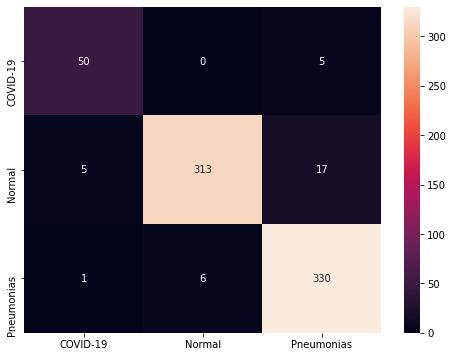

In [160]:
from sklearn.metrics import multilabel_confusion_matrix
conf_matrix = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))#, labels=["Normal", "COVID-19"])
plt.figure(figsize=(8, 6))

ax = sns.heatmap(conf_matrix, fmt=".0f", annot=True)
ax.set_yticklabels([ "COVID-19","Normal","Pneumonias"])
ax.set_xticklabels([ "COVID-19","Normal","Pneumonias"])
plt.show()


(2905, 4096)
Iniciando t-SNE...
t-SNE finalizado, plotando gráfico da distribuição...


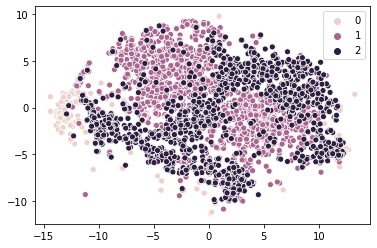

In [130]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=50, n_iter=300, n_iter_without_progress=100)

x_flattened = np.array(list(map(lambda x: x.flatten(), data)))
print(x_flattened.shape)
print("Iniciando t-SNE...")
x_embedded = tsne.fit_transform(x_flattened)
print("t-SNE finalizado, plotando gráfico da distribuição...")
sns.scatterplot(x_embedded[:, 0], x_embedded[:, 1], hue=labels, )


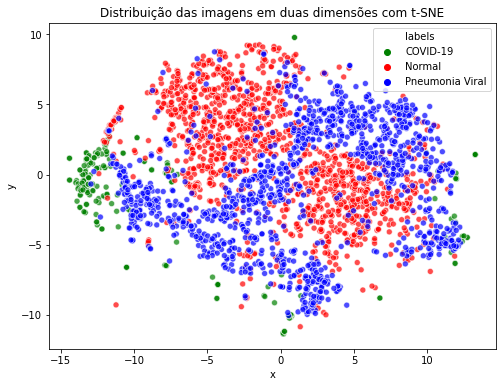

In [131]:
import pandas as pd
three_classes_df = pd.DataFrame(dict(x=x_embedded[:, 0], y=x_embedded[:, 1], labels=labels))
three_classes_df["labels"] = three_classes_df["labels"].replace([0, 1, 2], ["COVID-19", "Normal", "Pneumonia Viral"])
plt.figure(figsize=(8, 6))
sns.scatterplot("x", "y", hue="labels", data=three_classes_df, palette=["green", "red", "blue"], legend="full", alpha=0.7)
plt.title("Distribuição das imagens em duas dimensões com t-SNE")
plt.legend(loc="best")
plt.show()